In [9]:
# Add path to other HW folders / Modular Design
import sys
sys.path.append("../")

# Import modules
import numpy as np
import astropy.units as u
from astropy.constants import G
import astropy.table as tbl
from Homework2.ReadFile import Read
from Homework4.CenterOfMass import CenterOfMass
import matplotlib.pyplot as plt
from matplotlib import rcParams

##  Mass Profile Class

In [70]:
class MassProfile:
    """
    :param galaxy: a Galaxy name, e.g. "MW", "M31" or "M33"
    :param snap: snapshot number, e.g. 0, 1, etc
    """
    
    def __init__(self, galaxy, snap):
        """
        
        """
        
        # Reconstruct the filename
        # Format: 'GalaxyName_SnapNum.txt'
        # SnapNum - three digits zero-padding integer
        self.filename= f'{galaxy:s}_{snap:03d}.txt'
        
        # Save the other params
        self.gname = galaxy[-3:].upper()
        self.snap = snap
        
    def MassEnclosed(self, ptype, r, delta=0.1):
        """
        compute the mass enclosed within a given radius of the COM 
        position for a specified component of the galaxy.
        
        :param ptype:
        :param r: array of radii  (kpc)
        :param delta: tolerance for COM iterative estimation
        :return:
        """
        # Get CenterOfMass object, and compute its position
        com = CenterOfMass(self.filename, ptype)
        comp = com.COM_P(delta).value
        
        # Make sure input radii is an array, could be a list or scalar
        r_array = np.atleast_1d(r)
        
        # Switch particle coords to COM reference frame
        xNew = com.x - comp[0]
        yNew = com.y - comp[1]
        zNew = com.z - comp[2]
        # Calculate each particle's radial distance to COM
        rNew = np.sqrt(xNew**2 + yNew**2 + zNew**2)
        
        # Initialize array to store enclosed masses; same shape as radii array
        rMasses = np.zeros(r_array.size)
        
        # Loop over each radius
        for i in range(r_array.size):
            # select those within current radius r[i], and sum masses
            rMasses[i] = com.m[rNew < r_array[i]].sum()
        
        return rMasses * 1e10 * u.Msun

    def MassEnclosedTotal(self, r, delta=0.1, return_each=False):
        # Iterate over particle types, and calculate their mass enclosed
        ptypes = [1, 2, 3] if self.gname != 'M33' else [1, 2]
        # Save iterated MassEnclosed arrays into array
        rMasses = np.array([self.MassEnclosed(i, r, delta) for i in ptypes]) * u.Msun
        # Sum over their rows (one row per particle type) to get total masss profile
        rTotalMasses = rMasses.sum(axis=0)
        
        # Litte feature to return component mass profiles
        if return_each:
            return [rTotalMasses, *rMasses]
        else:
            return rTotalMasses

    def CircularVelocity(self, ptype, r, delta=0.1):
        """
        Calculate rotational velocity profile assuming spherical symmetry
        for each particle type; assuming the other aren't there as well.
        
        :param ptype:
        :param r:
        :param delta:
        :return:
        """
        Mass = MassEnclosed(ptype, r, delta)
        return np.sqrt(G * Mass / r).to(u.km/u.s)

    def CircularVelocityTotal(r):
        """
        Calculate rotational velocity profile assuming spherical symmetry
        
        :param r: 
        :return:
        """
        Mass = MassEnclosedTotal(r, delta)
        return np.sqrt(G * Mass / r).to(u.km/u.s)


def HernquistM(r, a=60, Mhalo=1.97):
    """
    Function that returns the Hernquist 1990 mass profile
    
    :param r: Distance from the center of the galaxy (kpc)
    :param a: the scale radius (kpc)
    :param Mhalo: the total dark matter halo mass (10^12 Msun)
    :return: total dark matter halo mass within r (Msun)
    """
    return np.round(Mhalo * r**2 / (a + r)**2, 2) * u.Msun
        
    
def HernquistVCirc(r, a=60, Mhalo=1.97):
    Mass = HernquistM(r, a, Mhalo)
    return np.sqrt(G * Mass / (r * u.kpc)).to(u.km/u.s)


In [71]:
mw_str = '../../SampleData/MW'
m31_str = '../../SampleData/M31'
m33_str = '../../SampleData/M33'

In [76]:
r = np.linspace(0.1, 30.0, 1000)
MW = MassProfile(mw_str, 0)

MWTotalProfile, MWHaloProfile, MWDiskProfile, MWBulgeProfile = MW.MassEnclosedTotal(r, return_each=True)

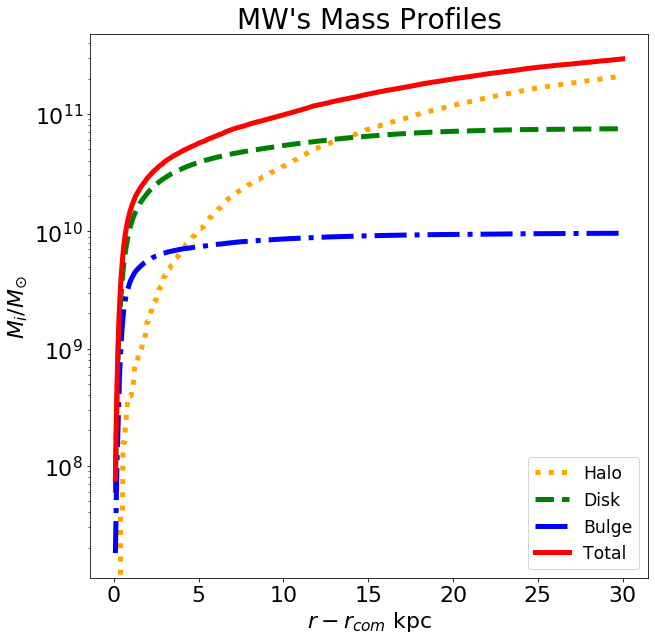

In [77]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

ax.semilogy(r, MWHaloProfile, color='orange', linewidth=5, linestyle=':',label='Halo')
ax.semilogy(r, MWDiskProfile, color='green', linewidth=5, linestyle='--',label='Disk')
ax.semilogy(r, MWBulgeProfile, color='blue', linewidth=5, linestyle='-.',label='Bulge')
ax.semilogy(r, MWTotalProfile, color='red', linewidth=5, linestyle='-',label='Total')

#adjust tick label font size
label_size = 22
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels
ax.set_xlabel(r'$r - r_{com}$ kpc', fontsize=22)
ax.set_ylabel(r'$M_{i} / M_{\odot}$', fontsize=22)

# Add title
ax.set_title('MW\'s Mass Profiles', fontsize=28)

# add a legend with some customizations.
ax.legend(loc='lower right',fontsize='xx-large')

plt.show()